```
This notebook sets up and runs a set of benchmarks to compare
different numerical discretizations of the SWEs

Copyright (C) 2016  SINTEF ICT

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

#Import packages we need
import numpy as np
from matplotlib import animation, rc, patches
from matplotlib import pyplot as plt

import pyopencl
import subprocess
import os
import StringIO
import gc
import time
import sys

#Set large figure sizes
rc('figure', figsize=(16.0, 12.0))
rc('animation', html='html5')

#Finally, import our simulator
from SWESimulators import FBL, CTCS, LxF, FORCE, HLL, HLL2, KP07, KP07_dimsplit, WAF, CDKLM16, DataOutput, PlotHelper

In [2]:
#Make sure we get compiler output from OpenCL
os.environ["PYOPENCL_COMPILER_OUTPUT"] = "1"

#Set which CL device to use, and disable kernel caching
os.environ["PYOPENCL_CTX"] = "1"
os.environ["CUDA_CACHE_DISABLE"] = "1"
os.environ["PYOPENCL_COMPILER_OUTPUT"] = "1"
os.environ["PYOPENCL_NO_CACHE"] = "1"

#Create OpenCL context
cl_ctx = pyopencl.create_some_context()
print "Using ", cl_ctx.devices[0].name

Using  GeForce 840M


In [3]:
def setBwStyles(ax):
    from cycler import cycler

    ax.set_prop_cycle( cycler('marker', ['.', 'x', 4, '+', '*', '1']) +
                       cycler('linestyle', ['-.', '--', ':', '-.', '--', ':']) +
                       #cycler('markersize', [5, 5, 5, 5, 5, 5]) +
                       cycler('color', ['k', 'k', 'k', 'k', 'k', 'k']) )

In [4]:
#Taken from https://github.com/alexanderkuk/log-progress
#Unknown license. Fair use? 
def log_progress(sequence, every=None, size=None):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = size / 200     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{index} / ?'.format(index=index)
                else:
                    progress.value = index
                    label.value = u'{index} / {size}'.format(
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = str(index or '?')

In [5]:
def gen_test_data(nx, num_ghost_cells):
    ny = nx
    width = 100.0
    height = width
    dx = width / float(nx)
    dy = height / float(nx)

    h = np.zeros((ny+2*num_ghost_cells, nx+2*num_ghost_cells), dtype=np.float32); 
    hu = np.zeros((ny+2*num_ghost_cells, nx+2*num_ghost_cells), dtype=np.float32);
    hv = np.zeros((ny+2*num_ghost_cells, nx+2*num_ghost_cells), dtype=np.float32);

    #Create a gaussian "dam break" that will not form shocks
    x_center = dx*nx/2.0
    y_center = dy*ny/2.0
    size = width / 5.0
    for j in range(-num_ghost_cells, ny+num_ghost_cells):
        y = dy*(j+0.5) - y_center
        for i in range(-num_ghost_cells, nx+num_ghost_cells):
            x = dx*(i+0.5) - x_center
            
            h[j+num_ghost_cells, i+num_ghost_cells] = 0.5 + 0.1*np.exp(-(x**2/size + y**2/size))
            #hu[j+num_ghost_cells, i+num_ghost_cells] = 0.01*np.sin(x)*np.exp(-(x**2/size))
            hu[j+num_ghost_cells, i+num_ghost_cells] = 0.1*np.exp(-(x**2/size + y**2/size))
            hv[j+num_ghost_cells, i+num_ghost_cells] = 0.1*np.exp(-(x**2/size + y**2/size))
    
    return h, hu, hv, dx, dy, nx, ny

In [6]:
def run_benchmark(simulator, h0, hu0, hv0, dx, dy, nx, ny, block_width, block_height, iters=500, g=9.81):

    max_u = 1.0; #Estimate of maximum velocity for dt
    courant_number = 0.45
    dt = courant_number * dx / (max_u + np.sqrt(g*0.6))

    #Initialize simulator
    try:
        sim = simulator(cl_ctx,
                        h0, hu0, hv0, \
                        nx, ny, \
                        dx, dy, dt, \
                        g, \
                        block_width=block_width, block_height=block_height)
        t = sim.step(iters*dt)
        #h, hu, hv = sim.download()
    except:
        print("Could not run block size " + str(block_width) + "x" + str(block_height) + ": " + str(sys.exc_info()[0]) )
        return False
    
    return True

In [7]:
#block_widths = range(4,32,2)
#block_heights = range(4,32,2) 
block_widths = [4, 8, 16, 32]
block_heights = [4, 8, 16, 32]
domain_size = 1024
simulators = [LxF.LxF, FORCE.FORCE, HLL.HLL, HLL2.HLL2, WAF.WAF, KP07.KP07, KP07_dimsplit.KP07_dimsplit]
simulator_ghost_cells = [1, 1, 1, 2, 2, 2, 2]
simulator_names = ['LxF', 'FORCE', 'HLL', 'HLL2', 'WAF', 'KP07', 'KP07 dimsplit']

In [8]:
def reset_context(simulator):
    cl_ctx = pyopencl.create_some_context()
    #Run a single simulation because the first after creating a context
    #is always slow
    success = run_benchmark(simulator, \
                            h0, hu0, hv0, dx, dy, nx, ny, \
                            8, 8, \
                            iters=1)

In [9]:
times = np.ma.masked_all((len(simulators), len(block_heights), len(block_widths)))


for k, simulator in enumerate(log_progress(simulators)):
    print simulator_names[k]

    #Generate test data
    h0, hu0, hv0, dx, dy, nx, ny = gen_test_data(domain_size, simulator_ghost_cells[k])
    
    #Reset the OpenCL context for each run
    reset_context(simulators[k])
    
    start = time.time()
    
    for j, block_height in enumerate(block_heights):
        for i, block_width in enumerate(block_widths):

            t0 = time.time()
            success = run_benchmark(simulators[k], \
                                    h0, hu0, hv0, dx, dy, nx, ny, \
                                    block_width, block_height, \
                                    iters=100)
            t1 = time.time()
            
            if (success):
                times[k, j, i] = t1 - t0;
                #print block_width, block_height, times[k, j, i]
            else:
                reset_context(simulators[k])
            
            
            gc.collect()
            
    end = time.time()
    print "Elapsed: " + str(end-start) + " s"

LxF
Elapsed: 7.21200013161 s
FORCE
Elapsed: 7.65899991989 s
HLL
Elapsed: 8.40899991989 s
HLL2
Elapsed: 14.3510000706 s
WAF
Elapsed: 13.1600000858 s
KP07
Could not run block size 32x32: <class 'pyopencl.RuntimeError'>
Elapsed: 19.8729999065 s
KP07 dimsplit
Elapsed: 11.0179998875 s


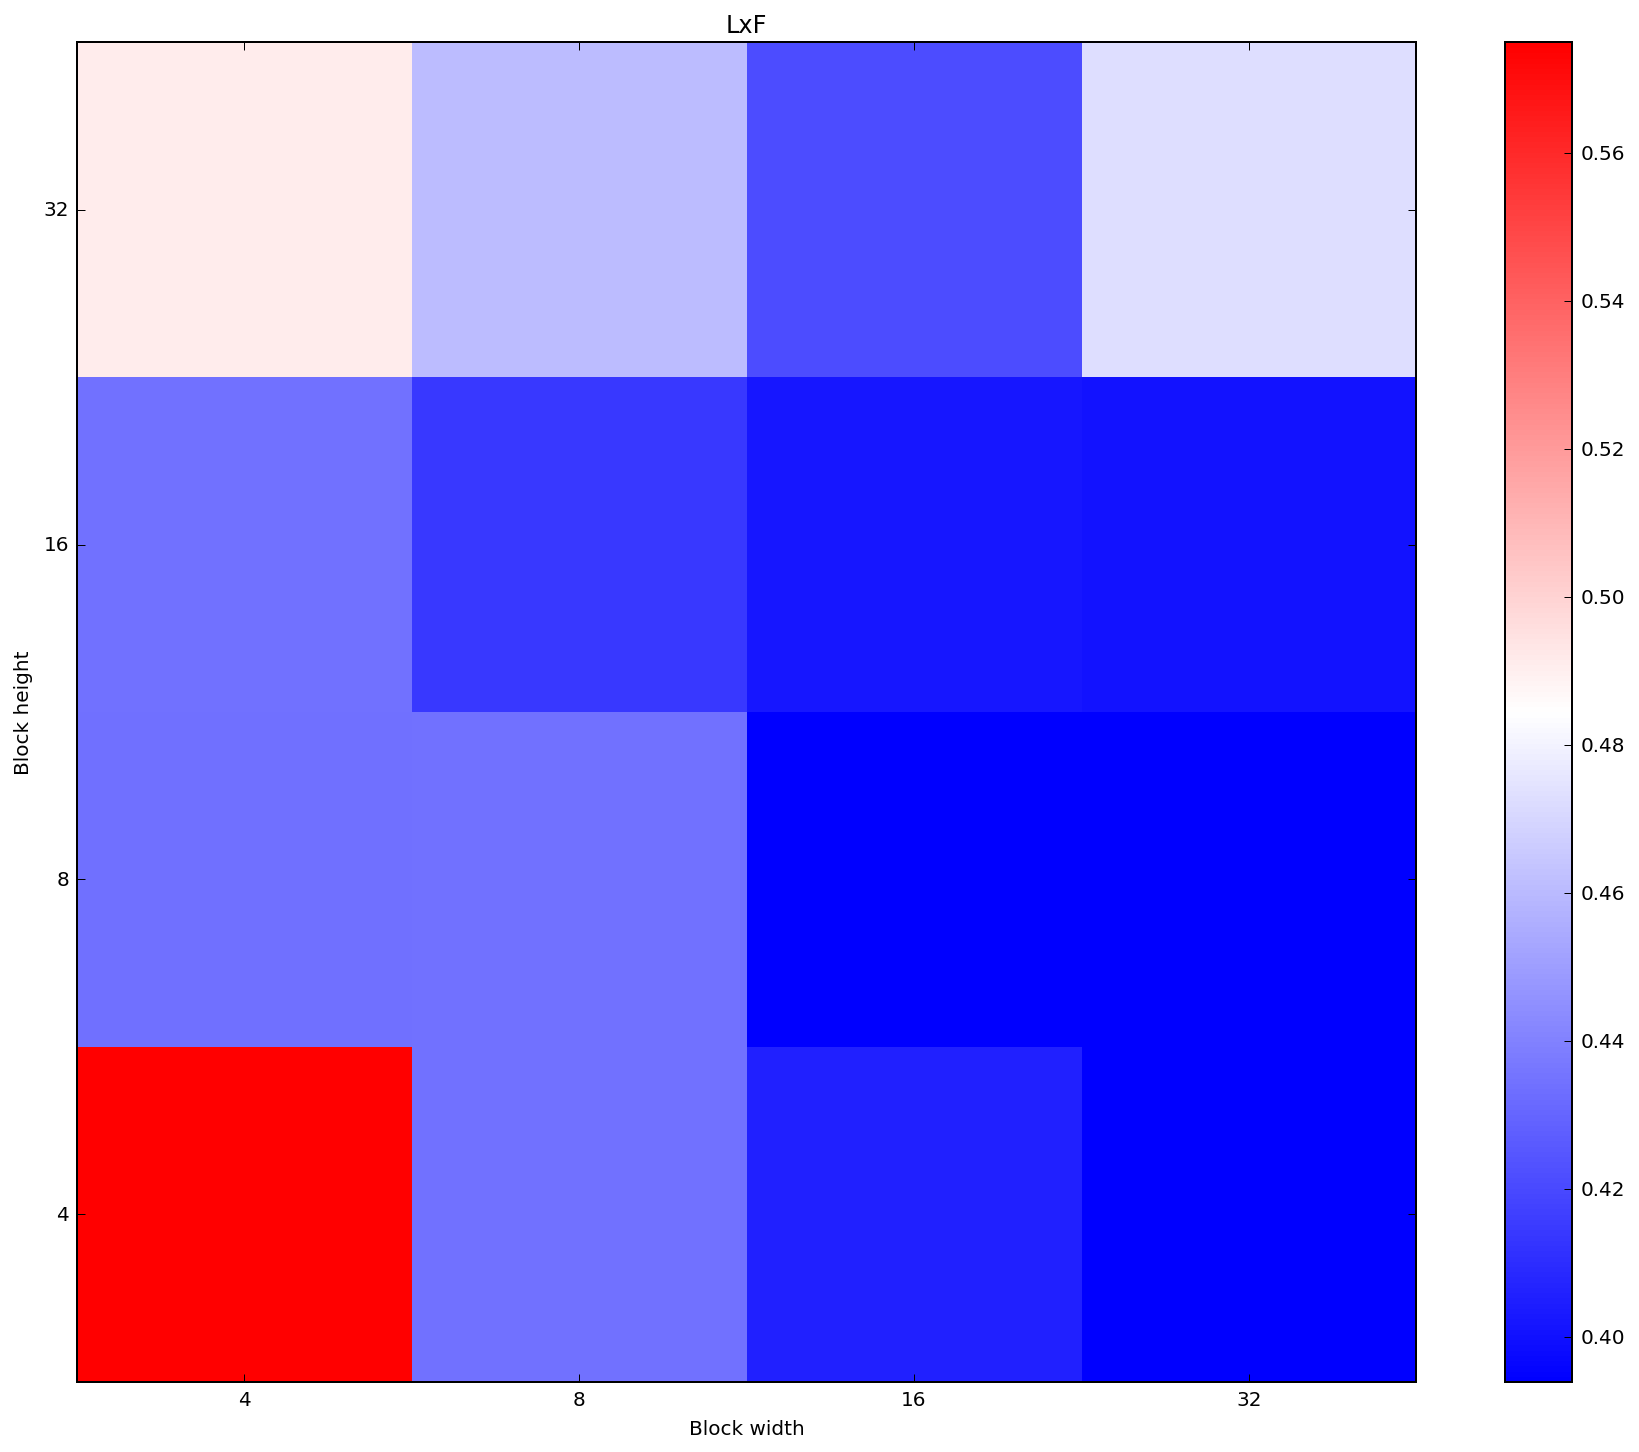

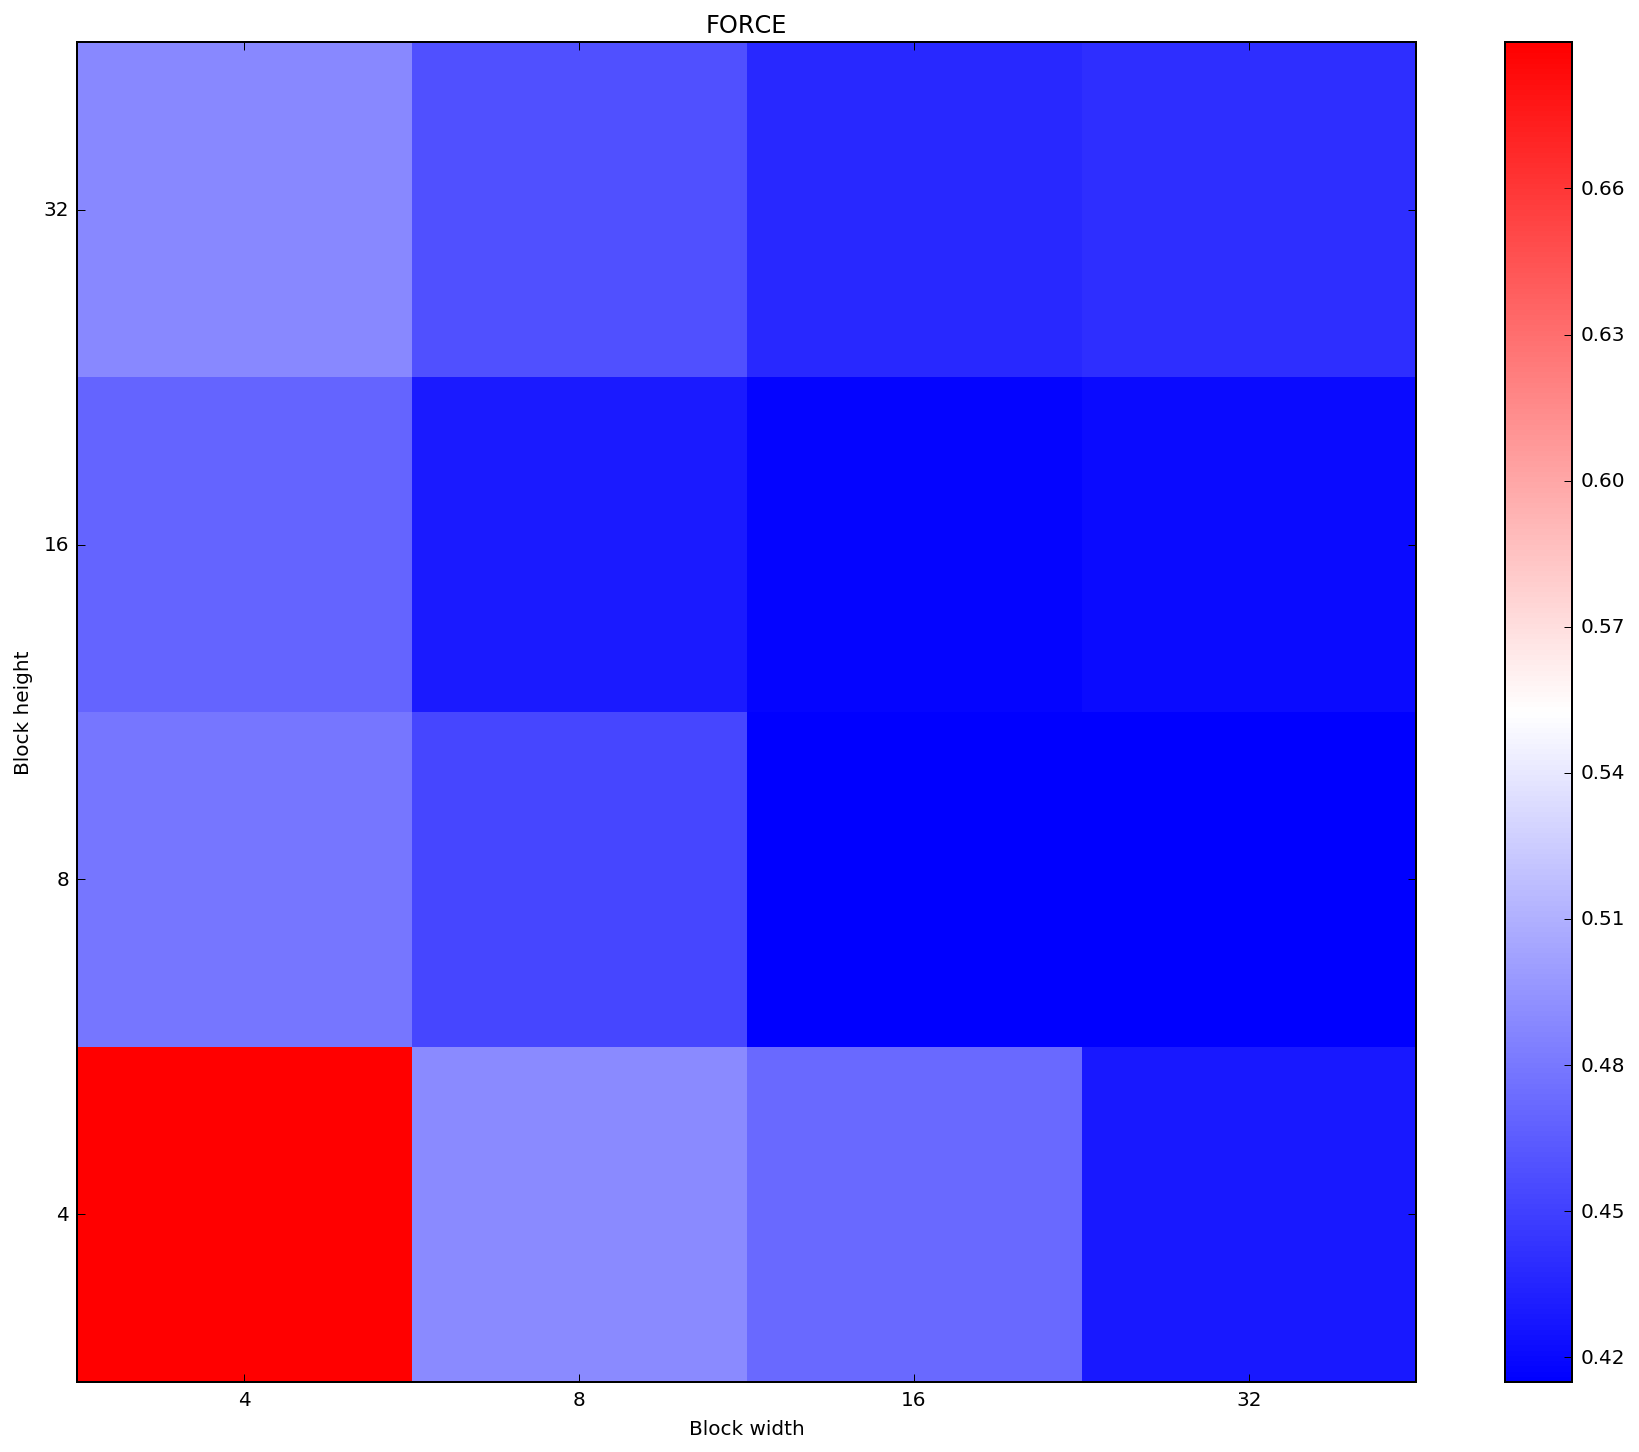

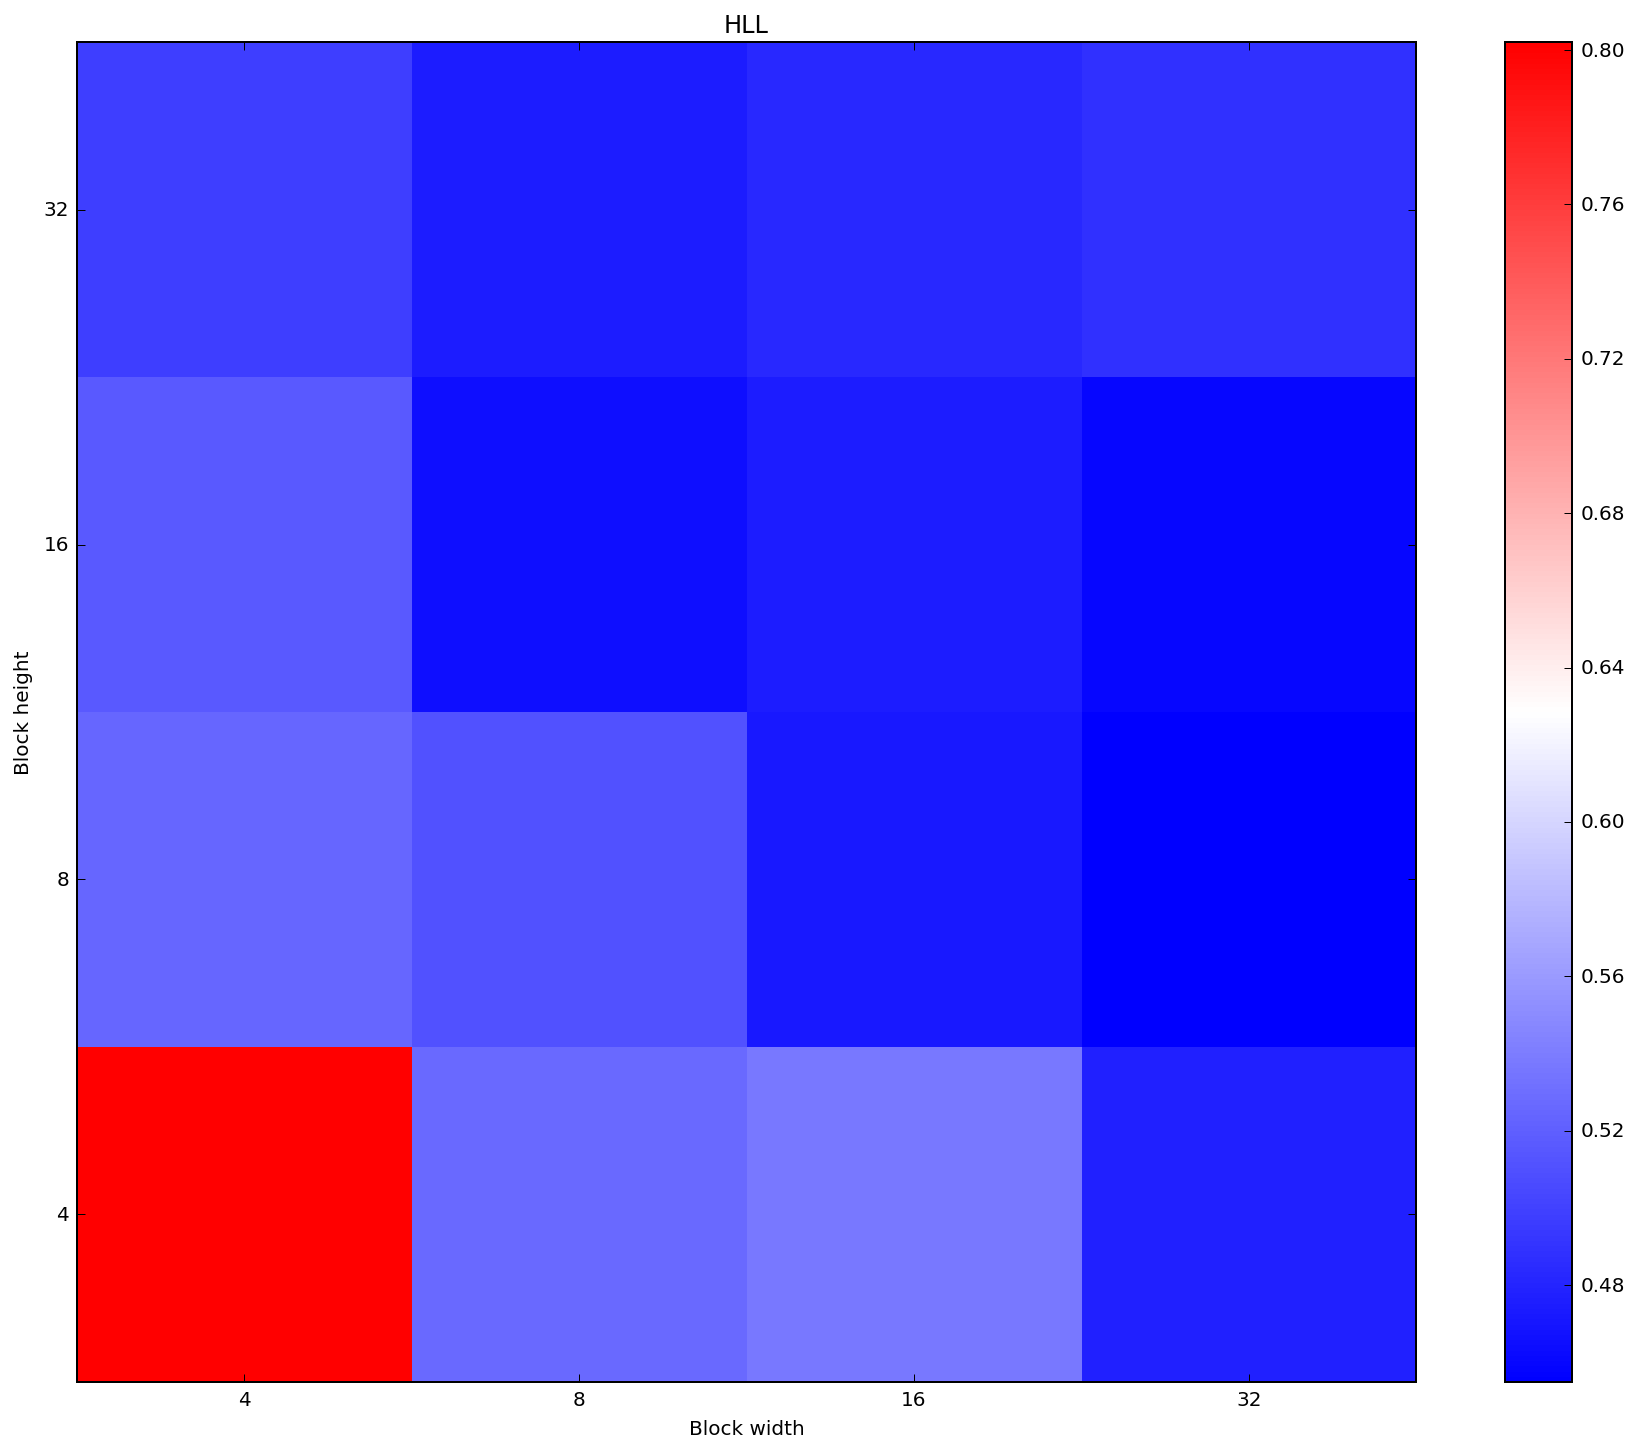

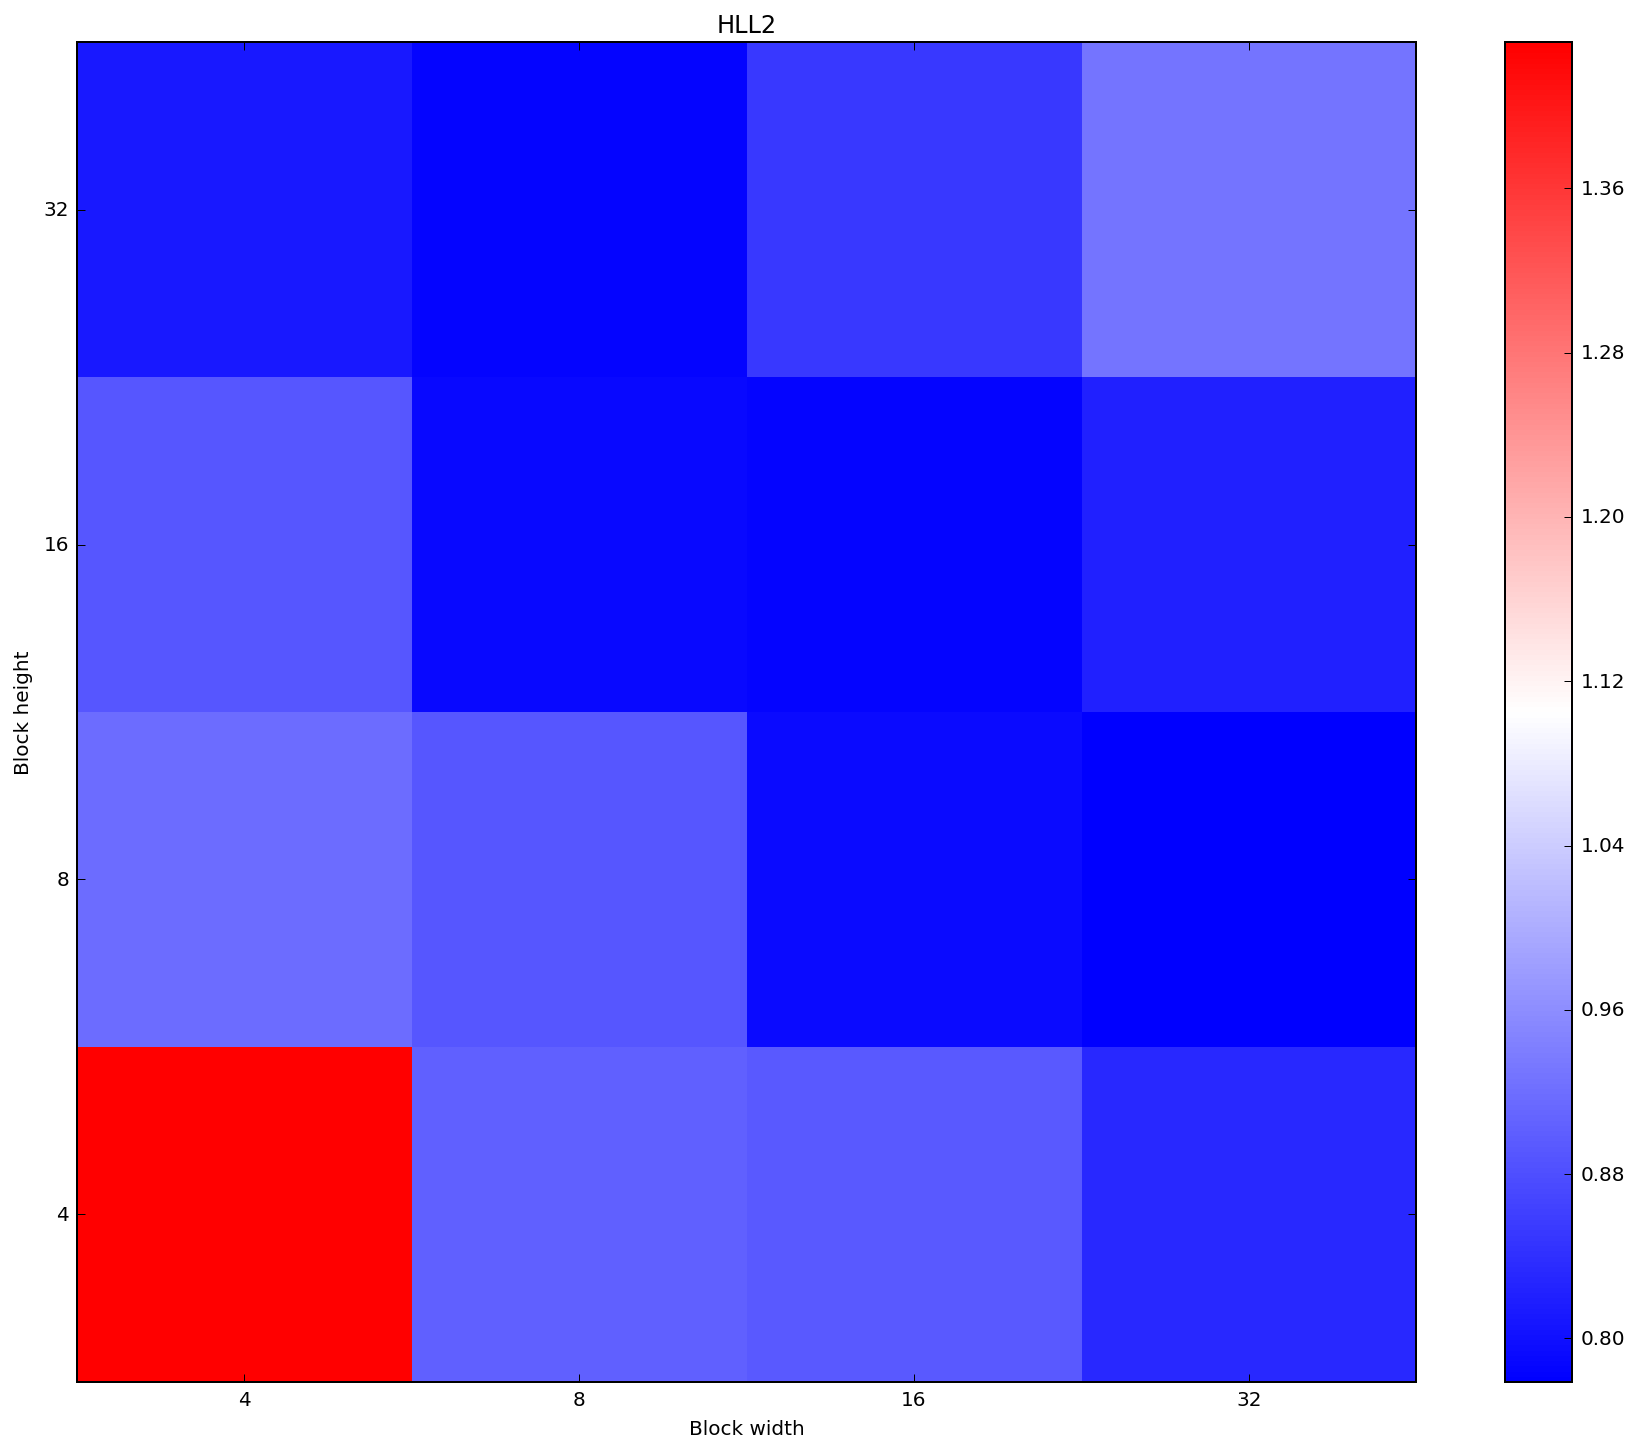

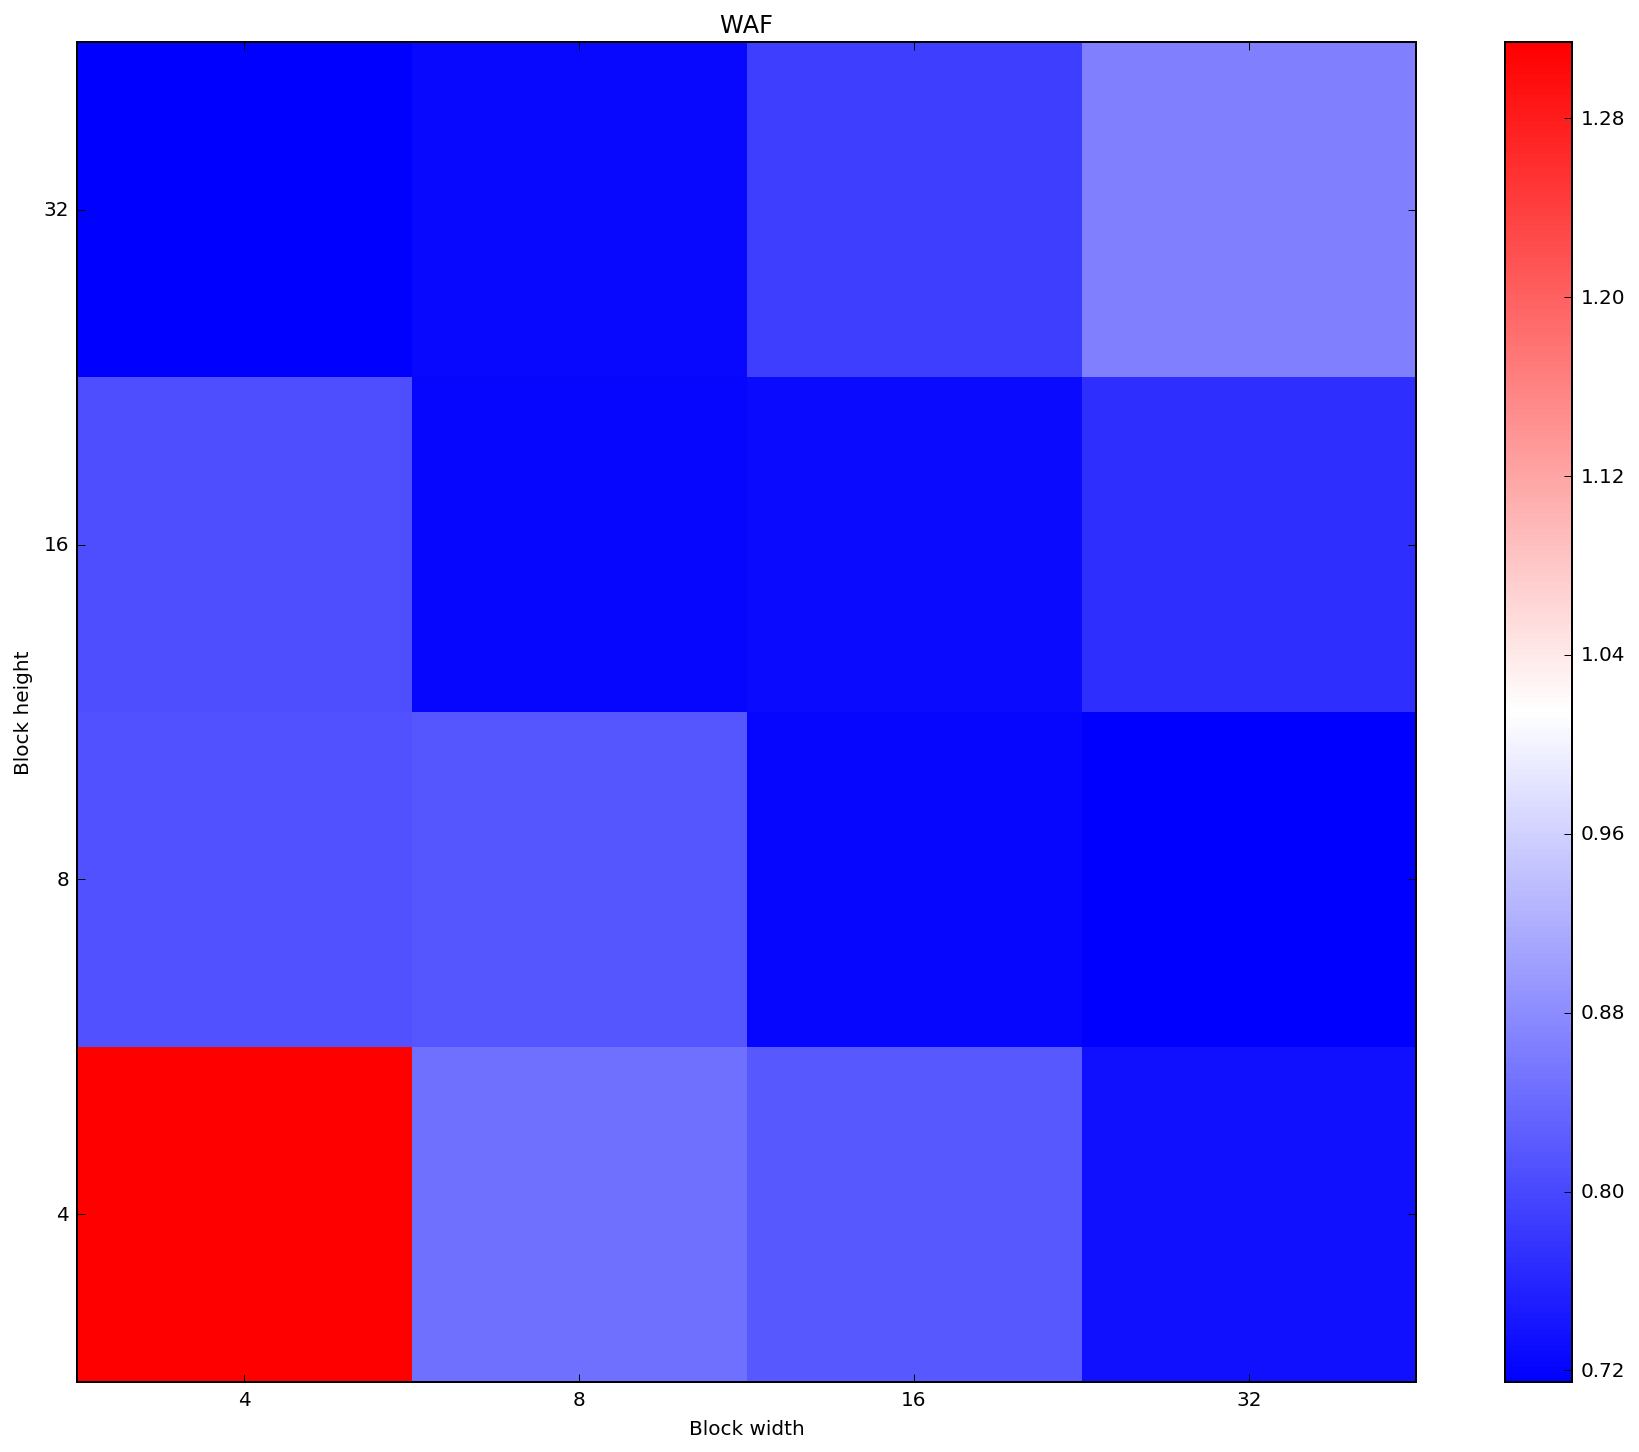

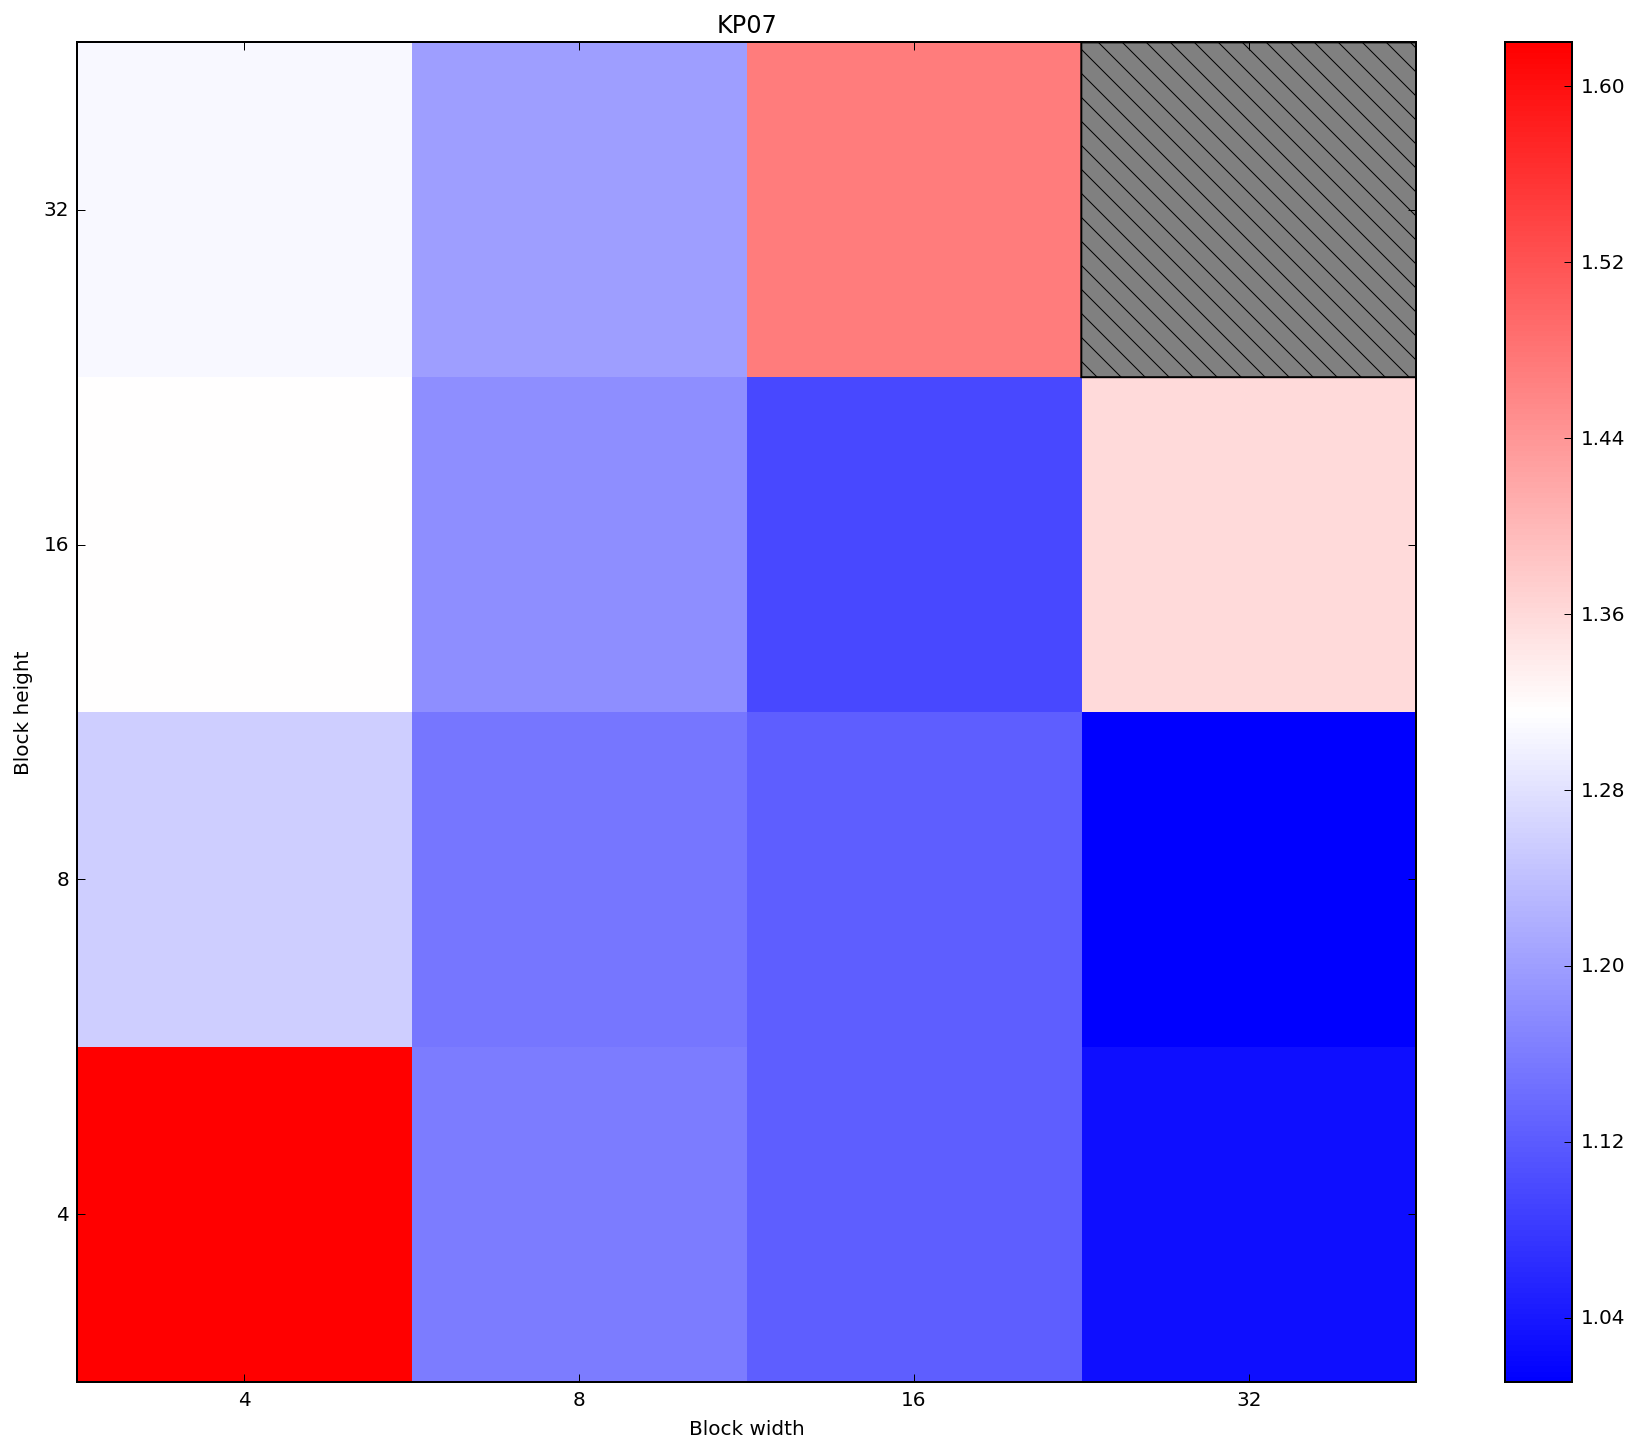

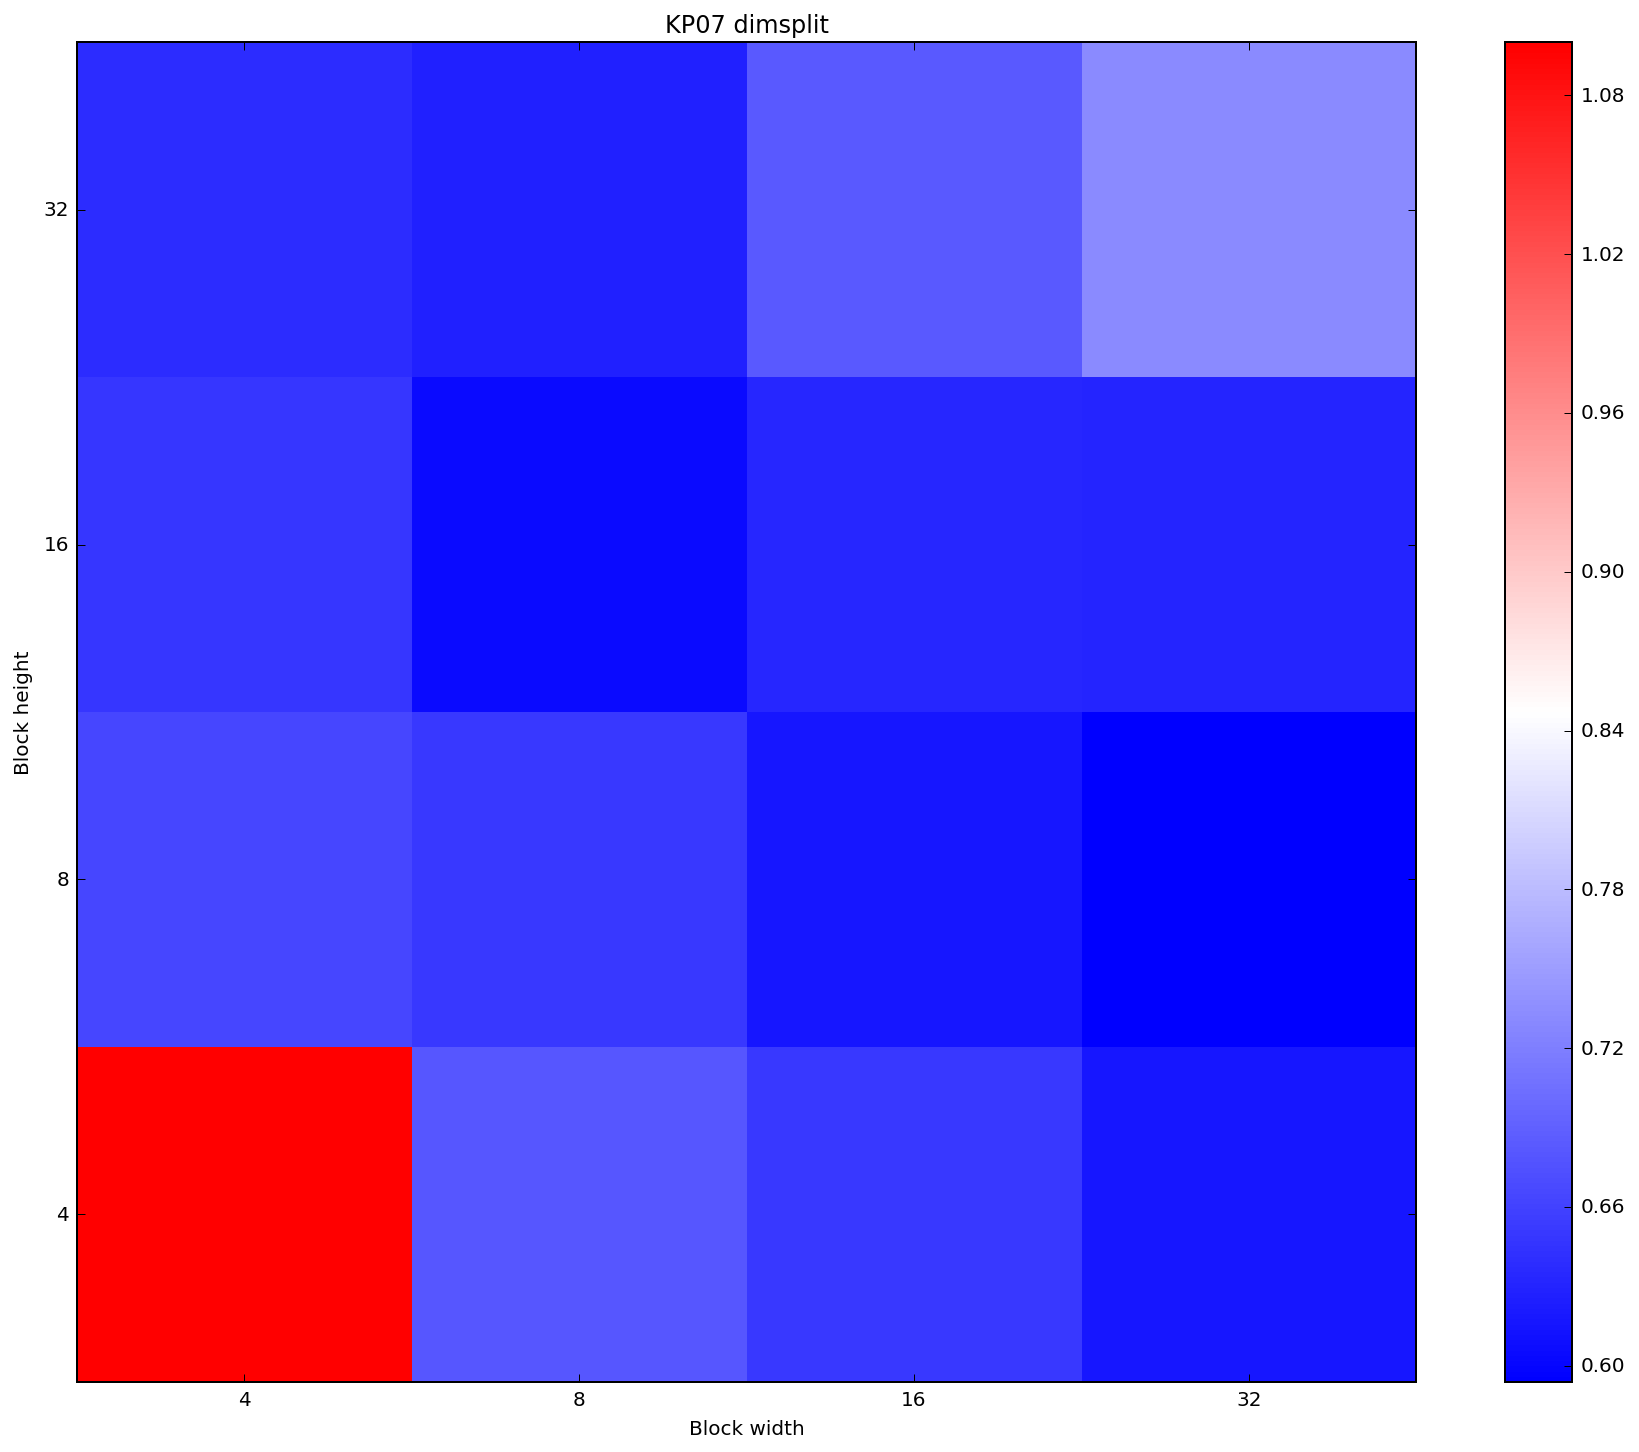

In [10]:
min_time = np.min(times)
max_time = np.max(times)

for k, simulator in enumerate(simulators):
    plt.figure()
    plt.title(str(simulator_names[k]))
    
    cmap = plt.cm.bwr
    cmap.set_bad('gray')
    plt.imshow(times[k,:,:], interpolation='nearest', cmap=cmap, origin='lower')#, vmin=min_time, vmax=max_time)
    
    # Shade nans
    nans = np.where(times[k,:,:].mask)
    if (nans[0].size > 0):
        for i,j in  zip(*nans):
            plt.gca().fill([i-.5, i+.5, i+.5, i-.5], [j-.5, j-.5, j+.5, j+.5], hatch='\\', fill=False, snap=False)

    
    plt.xlabel('Block width')
    plt.xticks(range(len(block_widths)), block_widths)
    
    plt.ylabel('Block height')
    plt.yticks(range(len(block_heights)), block_heights)
    
    plt.colorbar()
    plt.show()